In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import pickle

# Set random seed for reproducibility
np.random.seed(42)

# Comparison of Neural Network versus Polynomial Regression
I have a dataset with 100 points that are nonlinear. We'll use polynomial regression, a basic neural network, and the sklearns MLRegressor to fit the data and see how they compare.

## Generate synthetic data

In [2]:
x = np.linspace(0, 10, 100)
y =  - 2.5 * x + 3 + np.random.normal(1,2,size=x.shape)
#perhaps add some non-linearity
y += 3 * (np.log((x-4)**2))

## Now fit a polynomial regression model

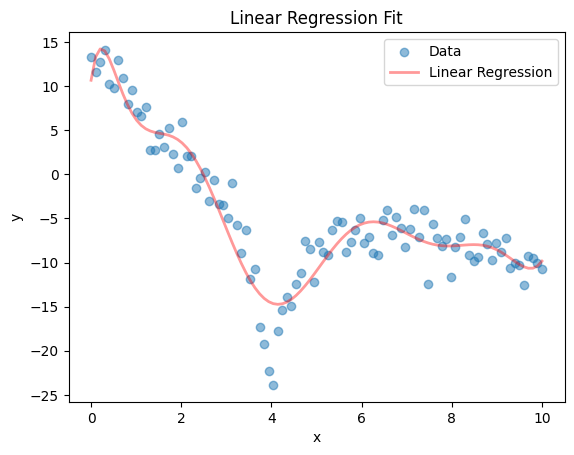

In [3]:
#or using np.polyfit
coeffs = np.polyfit(x, y, 10)
# Generate predictions from polynomial model
y_pred_poly = np.polyval(coeffs, x)

#plot linear regression results
plt.scatter(x, y, label='Data', alpha=0.5)
plt.plot(x, y_pred_poly, color='red', label='Linear Regression', linewidth=2, alpha = 0.4)
plt.xlabel('x'); plt.ylabel('y')
plt.title('Linear Regression Fit')
plt.legend(); plt.show()

## Now complete regression using a neural network with stochastic gradient descent

In [4]:
# Define layer sizes
n_x = 1  # Number of input features
n_h = 20  # Number of parameters in hidden layer
n_y = 1 # Output size

# --- Initialize Parameters ---
# Input layer 
W1 = np.random.randn(n_h, n_x) * 0.2
b1 = np.zeros((n_h, 1))

#add another layer
W2 = np.random.randn(n_h, n_h) * 0.2
b2 = np.zeros((n_h, 1))

# Hidden to output layer
W3 = np.random.randn(n_y, n_h) * 0.2
b3 = np.zeros((n_y, 1))

parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}

print(f"Total Parameters: {W1.size + b1.size + W2.size + b2.size + W3.size + b3.size}")

Total Parameters: 481


In [5]:
#check to see if pickle file exists and load parameters if so
import os
if os.path.exists('nn_parameters.pkl'):
    with open('nn_parameters.pkl', 'rb') as f:
        parameters = pickle.load(f)

In [6]:
def forward_propagation(xval, parameters):
    xNN = np.array(xval).reshape(-1,1)
    W1 = parameters['W1']; b1 = parameters['b1']
    W2 = parameters['W2']; b2 = parameters['b2']
    W3 = parameters['W3']; b3 = parameters['b3']
    
    Z1 = np.dot(W1, xNN) + b1
    A1 = np.maximum(0, Z1)  # ReLU activation
    Z2 = np.dot(W2, A1) + b2
    A2 = np.maximum(0, Z2)  # ReLU activation

    Z3 = np.dot(W3, A2) + b3
    
    return (Z3, A2, Z2, A1, Z1)

In [7]:
def backpropagation(x, y, parameters):
    xNN = x.reshape(-1,1)
    yNN = y.reshape(-1,1)
    
    W2 = parameters['W2']; W3 = parameters['W3']
    
    # Forward pass
    Z3, A2, Z2, A1, Z1 = forward_propagation(x,parameters)
    
    # Backward pass
    dZ3 = Z3 - yNN
    dW3 = np.dot(dZ3, A2.T); db3 = np.sum(dZ3, axis=1, keepdims=True)
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = dA2 * (Z2 > 0)  # Derivative of ReLU

    dW2 = np.dot(dZ2, A1.T); db2 = np.sum(dZ2, axis=1, keepdims=True)
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = dA1 * (Z1 > 0)  # Derivative of ReLU
    dW1 = np.dot(dZ1, xNN.T); db1 = np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3": db3}
    
    return grads

In [8]:
def update_parameters(parameters, grads, learning_rate=0.01):
    W1 = parameters['W1']; b1 = parameters['b1']
    W2 = parameters['W2']; b2 = parameters['b2']
    W3 = parameters['W3']; b3 = parameters['b3']
    
    dW1 = grads['dW1']; db1 = grads['db1']
    dW2 = grads['dW2']; db2 = grads['db2']
    dW3 = grads['dW3']; db3 = grads['db3']
    
    W1 -= learning_rate * dW1; b1 -= learning_rate * db1
    W2 -= learning_rate * dW2; b2 -= learning_rate * db2
    W3 -= learning_rate * dW3; b3 -= learning_rate * db3

    #include random noise to escape local minima
    W1 += np.random.randn(*W1.shape) * 0.0001
    W2 += np.random.randn(*W2.shape) * 0.0001 
    W3 += np.random.randn(*W3.shape) * 0.0001
    
    updated_parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}
    
    return updated_parameters

In [9]:
forward_propagation(x[4], parameters)[0].flatten()[0]

10.852053527520699

In [10]:
#complete training loop
num_iterations = 2000
learning_rate = 0.001
yhat = np.zeros_like(y)
for i in range(num_iterations+1):
    #update parameters with backpropagation
    for idx in range(len(x)):
        grads = backpropagation(np.array([x[idx]]), np.array([y[idx]]), parameters)
        parameters = update_parameters(parameters, grads, learning_rate)
    
    #print loss every 100 iterations
    if i % 500 == 0:
        #make predictions for each point x and update yhat array
        for idx in range(len(x)):
            yhat[idx] = forward_propagation(x[idx], parameters)[0].flatten()[0]
        #calculate loss
        loss = np.mean((yhat - y) ** 2)
        print(f"Iteration {i}, Loss: {loss}")

Iteration 0, Loss: 3.3729622161873247
Iteration 500, Loss: 3.701839926423202
Iteration 1000, Loss: 3.856300871463428
Iteration 1500, Loss: 3.3685443084520217
Iteration 2000, Loss: 3.4019258665392385


In [11]:
#compare loss to linear regression
loss, np.mean((y_pred_poly - y) ** 2)

(3.4019258665392385, 6.073022912820902)

In [12]:
xar = np.linspace(0, 10, 1000)
yhat2 = np.zeros_like(xar)
for idx in range(len(xar)):
    yhat2[idx] = forward_propagation(xar[idx], parameters)[0].flatten()[0]

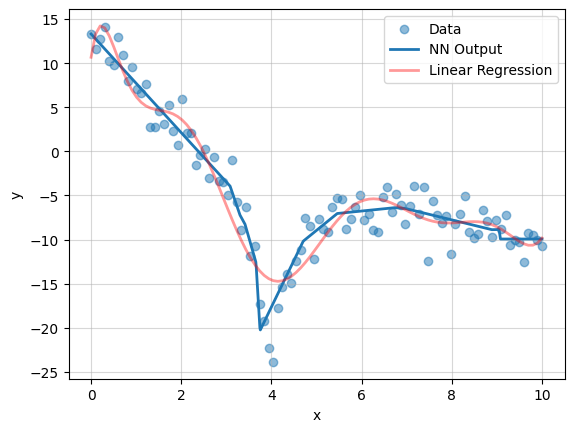

In [13]:
#plot NN output
plt.scatter(x, y, label='Data', alpha=0.5)
plt.plot(xar, yhat2, label='NN Output', linewidth=2)
plt.plot(x, y_pred_poly, color='red', label='Linear Regression', linewidth=2, alpha = 0.4)
plt.xlabel('x'); plt.ylabel('y')
plt.legend();plt.grid(alpha=0.5); 
#plt.savefig('NN_vs_Linear_Regression.png', dpi=300); 
plt.show()

In [14]:
#Output weights and biases to file
#with open('nn_parameters.pkl', 'wb') as f:
#    pickle.dump(parameters, f)

In [15]:
#make predictions with trained NN for single value
x_new = 0.01
y_new_pred = forward_propagation(x_new, parameters)[0].flatten()[0]
print(f"Prediction for x={x_new}: y={y_new_pred}")

Prediction for x=0.01: y=13.261498860063163


In [16]:
#use mlpregressor
mlp = MLPRegressor(hidden_layer_sizes=(20,20), activation='relu', solver='adam', max_iter=20000, random_state=42)
mlp.fit(x.reshape(-1,1), y)
y_mlp_pred = mlp.predict(x.reshape(-1,1))

In [17]:
#get loss function
mlp_loss = np.mean((y_mlp_pred - y) ** 2)
print(f"MLP Regressor Loss: {mlp_loss}")

MLP Regressor Loss: 3.055691696468867


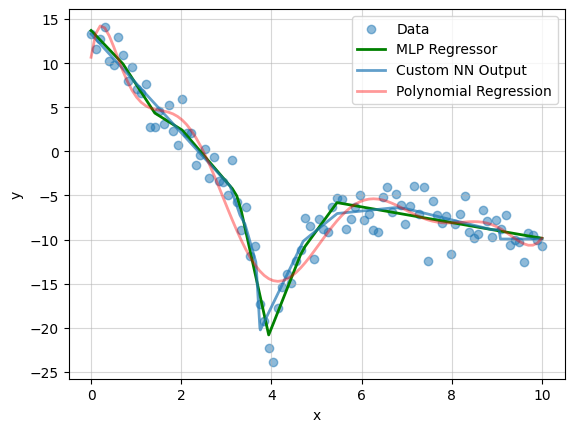

In [ ]:
#plot mlp results
plt.scatter(x, y, label='Data', alpha=0.5)
plt.plot(x, y_mlp_pred, color='green', label='MLP Regressor', linewidth=2)
plt.plot(xar, yhat2, label='Custom NN Output', linewidth=2, alpha=0.7)
plt.plot(x, y_pred_poly, color='red', label='Polynomial Regression', linewidth=2, alpha = 0.4)
plt.xlabel('x'); plt.ylabel('y');
plt.legend();plt.grid(alpha=0.5);
#plt.savefig('NN_vs_Polynomial_Regression.png', dpi=300)
plt.show()